In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import pandas as pd
import yaml
import geopandas as gp
import time
import pandas as pd
from geopy.distance import great_circle
import folium
import h5py
from scipy.signal import butter, lfilter

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import plotlib

In [3]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_01-03/'               # Harmon server
name_project

'project_repartition_v4.0/output_repar_v9.5_05--10-16Hz/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_05--10-16Hz/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
dir_image = dir_project + info_basic['rdir_image'] + 'regular_FJ/'
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [7]:
key_subworks = info_basic['key_subworks_repick_thresh']
nums_repick =[1]
key_subworks = []
for num in nums_repick:
    tag = str(num)
    for key_subwork in info_basic['key_subworks_repick_thresh'][:4]:
        if tag == key_subwork.split('--')[0]:
            key_subworks.append(key_subwork)
key_subworks

['1--16-03--0.06', '1--16-03--1', '1--16-03--0.05', '1--16-03--0.07']

In [8]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [9]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [10]:
stations = {}
lat = {}
lon = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)

In [11]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [12]:
ncffile = h5py.File(dir_CC + 'gather_all.h5','r')
ncfs = ncffile['ncfs'][:]
f = ncffile['f'][:]
count_all = ncffile['count'][:]
ncffile.close()

In [13]:
def Pairs(sta):
    p = []
    nsta = len(sta)
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            p.append([sta[ii],sta[jj]])
    return p
def cal_indx(pair,nsta):
    indx = int(pair[0]*(2*nsta-pair[0]-1)/2+pair[1]-pair[0]-1)
    return indx

In [14]:
def time_window_filter(t,ncfst0,r,v_min,t0,a):
    ncfst = ncfst0.copy()
    for i in range(len(ncfst)):
        tag = r[i]/v_min
        #print(t0,tag)
        t1 = t[t>-tag-t0][t[t>-tag-t0]< tag+t0]
        start = np.where(t == t1[0])[0][0]
        end = np.where(t == t1[-1])[0][0]
        ncfst[i][start:end+1]= ncfst[i][start:end+1]* np.exp(-a*np.abs((tag-np.abs(t1))))
    return ncfst

In [15]:
flag_save = 0

start = 0 
interval = 10
flag_time = 0.02
tao = 0

c_map = 'jet'
v_min = 0.1
v_max = None
d_len = 31

xlim_f = [2,30]
xlim_T = [-1,1]

info_basic['v_min'] = v_min
info_basic['v_max'] = v_max
info_basic['c_map'] = c_map

In [16]:
ds_linear_all = {}
ds_remove_all = {}
index_ncfs = {}
rs = {}
for key_subwork in key_subworks:
    print(key_subwork+ '; '+str(key_subworks.index(key_subwork)+1)+'/'+str(len(key_subworks))+' subworks.')
    ds = h5py.File(dir_ds+'ds_'+str(key_subwork)+'.h5', 'r')
    ds_linear = plotlib.smooth_ds(ds['ds_linear'][0])
    ds_remove = plotlib.smooth_ds(ds['ds_remove'][0],level_c  =15,level_f=15)
    ds_linear_all[key_subwork] = ds_linear
    ds_remove_all[key_subwork] = ds_remove
    index_ncfs[key_subwork] = list(ds['index_ncfs'])
    rs[key_subwork] = np.array(ds['r'])
    ds.close()

1--16-03--0.06; 1/4 subworks.
1--16-03--1; 2/4 subworks.
1--16-03--0.05; 3/4 subworks.
1--16-03--0.07; 4/4 subworks.


1--16-03--0.06; 1/4 subworks.
1--16-03--1; 2/4 subworks.
1--16-03--0.05; 3/4 subworks.
1--16-03--0.07; 4/4 subworks.


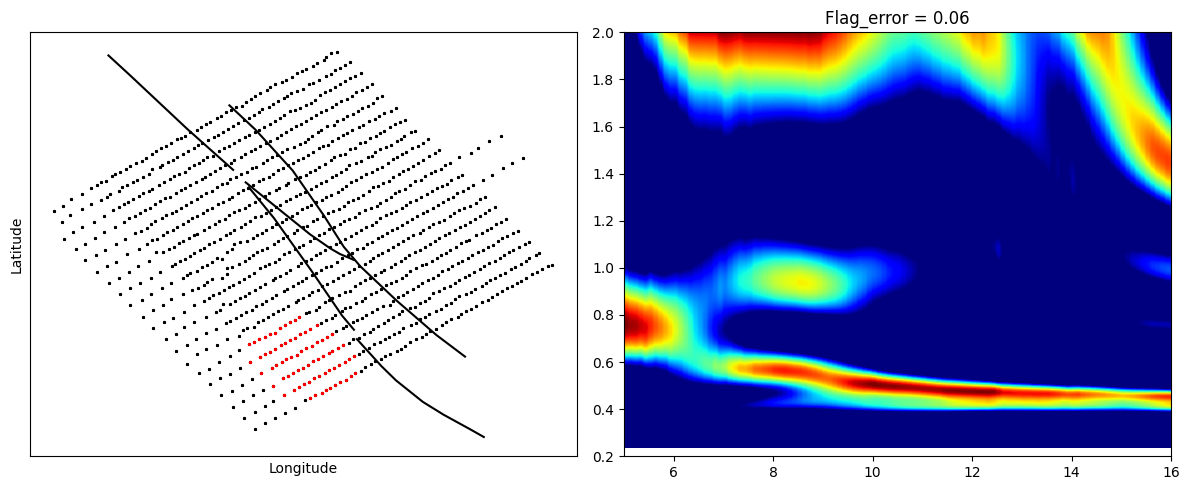

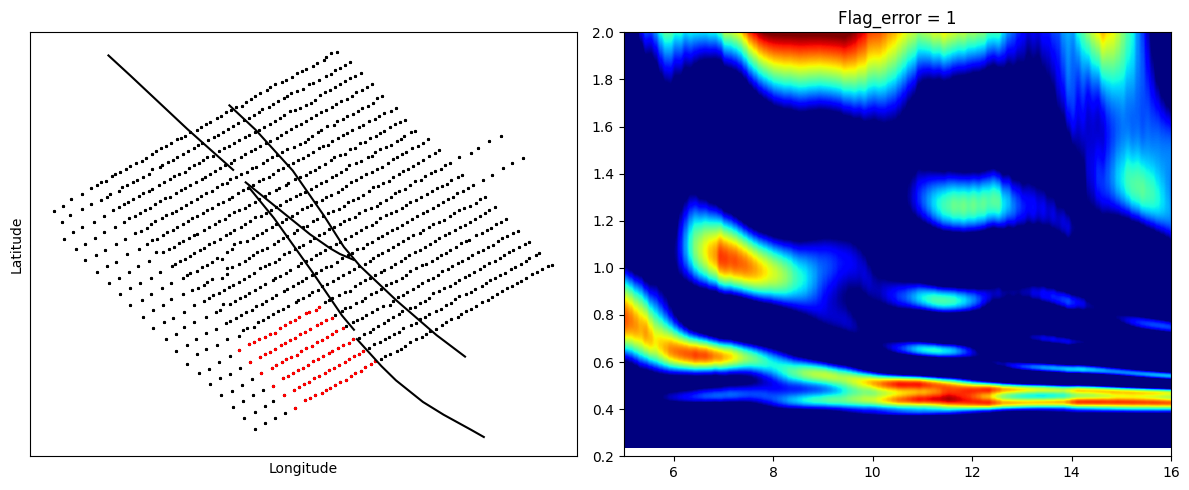

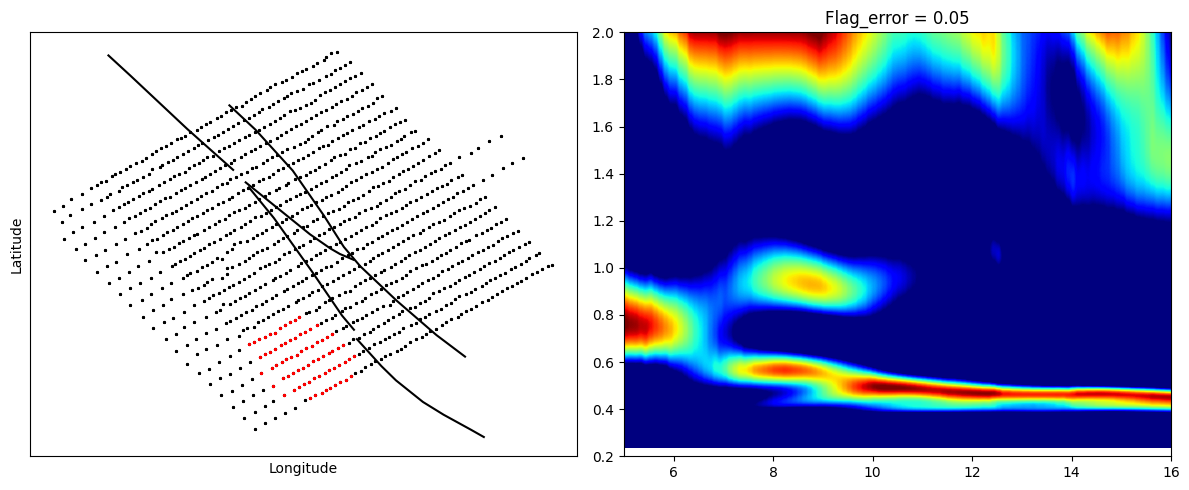

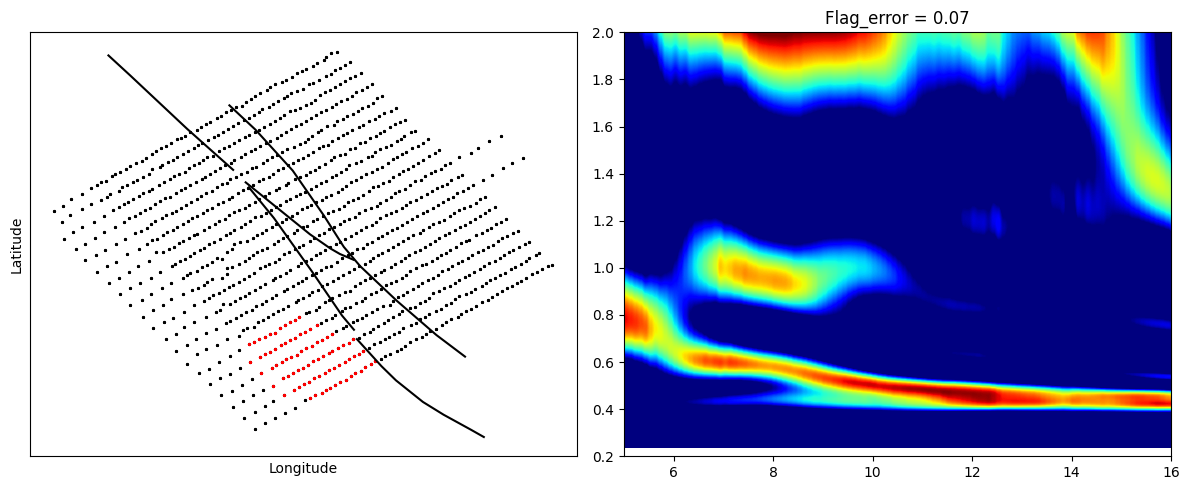

In [17]:
#%%capture
xlim_f = [5,16]
v_min = 0.2
v_max = 0.95
for key_subwork in key_subworks:
    print(key_subwork+ '; '+str(key_subworks.index(key_subwork)+1)+'/'+str(len(key_subworks))+' subworks.')
    #ncfs_sum_linear, r, StationPairs = linear_stack(key_subwork)
    
    index = index_ncfs[key_subwork]
    ncfs_sum_linear = np.array(ncfs)[index,:]
    r = rs[key_subwork]

    stalist = stations[key_subwork]
    lat_this = lat[key_subwork]
    lon_this = lon[key_subwork]
    nsta = len(stalist)
    StationPairs = mathlib.GetStationPairs(nsta)
    nPairs = int(len(StationPairs)/2)

    fig,ax = plt.subplots(1,2,figsize= (12,5))
    # plot area
    ax[0]=plotlib.plot_area(ax[0],lon_stations_all,lat_stations_all,lon_this,lat_this)
    for i in range(len(faults)):
        ax[0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')

    f0 = info_basic_bi['f']
    t = info_basic_bi['t']
    fs = info_basic['Fs']
    c = np.linspace(info_basic['fj_c_min'],info_basic['fj_c_max'],info_basic['fj_c_num'])

    title0 = "Flag_error = " + key_subwork.split('--')[2]
    ax[1] = plotlib.plot_fj(ax[1],ds_remove_all[key_subwork],title0,f0,c,0,v_min=v_min,v_max=v_max,c_map=c_map)
    ax[1].set_xlim(xlim_f)

    plt.tight_layout()
    plt.savefig(dir_image+str(key_subwork)+'_err_'+str(key_subwork.split('--')[2])+'.png',dpi=100)
    #plt.close()

In [18]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)